In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Historically, which teams performed best?

In [86]:
world_cups_df = pd.read_csv('WorldCups.csv')

winners_ser = world_cups_df['Winner'].value_counts()
runnersup_ser = world_cups_df['Runners-Up'].value_counts()
thirdplace_ser = world_cups_df['Third'].value_counts()

country_placers_df = pd.concat([winners_ser, runnersup_ser, thirdplace_ser], axis=1)
country_placers_df.fillna(0, inplace=True)
country_placers_df = country_placers_df.astype(int)
country_placers_df

,Winner,Runners-Up,Third
Brazil,5,2,2
Italy,4,2,1
Germany FR,3,3,1
Argentina,2,3,0
Uruguay,2,0,0
France,1,1,2
Spain,1,0,0
England,1,0,0
Germany,1,1,3
Netherlands,0,3,1


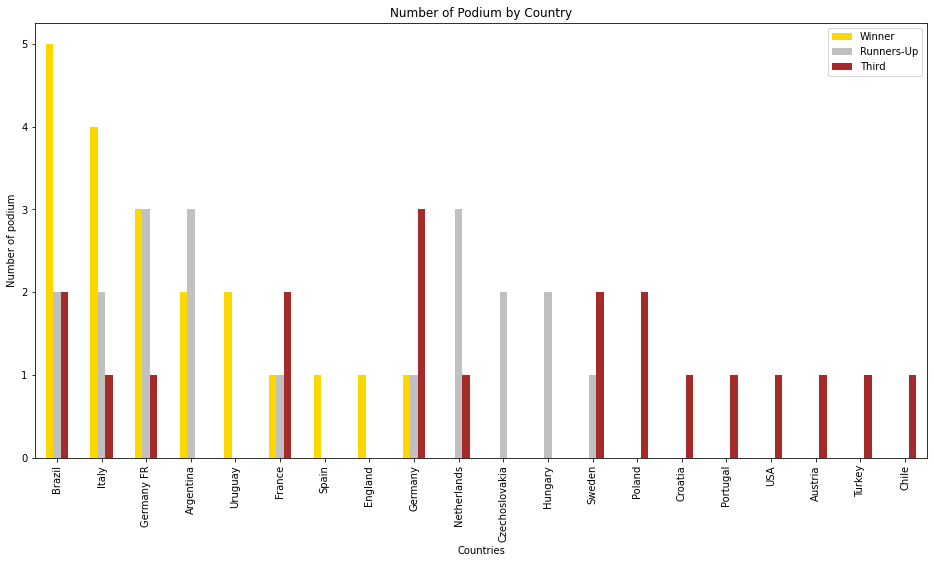

In [87]:
country_placers_df.plot(kind='bar', figsize=(16,8), color=['gold', 'silver', 'brown'])
plt.xlabel("Countries")
plt.ylabel("Number of podium")
plt.title("Number of Podium by Country");

However, world cup data isn't sufficient. Teams play a multitude of matches across years between world cups. We are therefore missing out on valuable data.

Using a new dataset, the graph belows illustrates the distribution of games played by match type.

In [91]:
df = pd.read_csv("results.csv")
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [94]:
# checking for any missing values in the columns
df.isnull().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

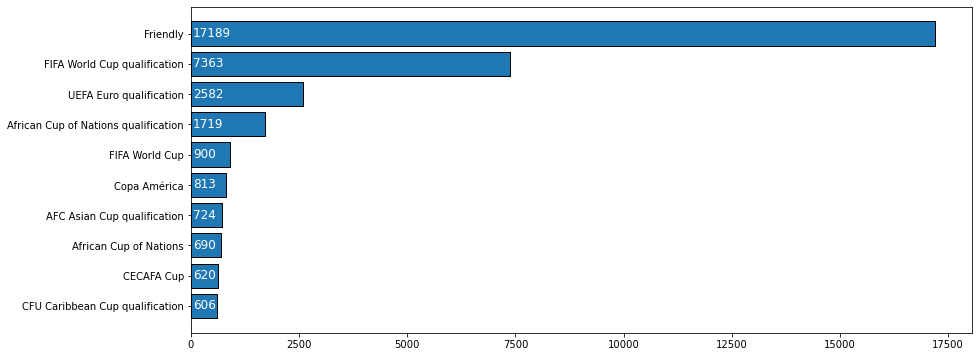

In [92]:
rank_bound = 10
ax = df.tournament.value_counts()[:rank_bound].sort_values()
value = ax.values
label = ax.index

plt.figure(figsize=(14,6))
plt.barh(y=label, width=value, edgecolor="k")
for i in range(rank_bound):
    plt.text(x=50,y=i-0.1,s=value[i],color="w",fontsize=12)
plt.show()

It is clear there is more to the picture. We will therefore proceed with this dataset. However, with mind of dimensionality, we will drop fields that are mainly categorical.

In [7]:
qualifiers = ["Qatar","Ecuador","Senegal","Netherlands","England","Iran","United States","Wales",
              "Argentina","Saudi Arabia","Mexico","Poland","France","Australia","Denmark","Tunisia",
              "Spain","Costa Rica","Germany","Japan","Belgium","Canada","Morocco","Croatia",
              "Brazil","Serbia","Switzerland","Cameroon","Portugal","Ghana","Uruguay","South Korea"]

Group_A= ["Qatar","Ecuador","Senegal","Netherlands"]
Group_B= ["England","Iran","United States","Wales"]
Group_C= ["Argentina","Saudi Arabia","Mexico","Poland"]
Group_D= ["France","Australia","Denmark","Tunisia"]
Group_E= ["Spain","Costa Rica","Germany","Japan"]
Group_F= ["Belgium","Canada","Morocco","Croatia"]
Group_G= ["Brazil","Serbia","Switzerland","Cameroon"]
Group_H= ["Portugal","Ghana","Uruguay","South Korea"]
Groups={"Group A":Group_A,"Group B":Group_B,"Group C":Group_C,"Group D":Group_D,"Group E":Group_E,
        "Group F":Group_F,"Group G":Group_G,"Group H":Group_H}

In [8]:
# Pre-Processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# We will try out the process with two different dataframes,
# one with only qualified teams, and the other with at least one
# qualified team.

# Limiting this dataframe to games where both of the teams playing
# have qualified for the 2022 World Cup.
df_q = df.copy()
df_q = df[df["team1"].isin(qualifiers) & df["team2"].isin(qualifiers)]

# Limiting the main dataframe to games where at least one of the teams playing
# has qualified for the 2022 World Cup.
df = df[df["team1"].isin(qualifiers) | df["team2"].isin(qualifiers)]

# Getting rid of column we don't need
df = df.drop(["city","country","neutral","tournament"], axis=1)
df_q = df_q.drop(["city","country","neutral","tournament"], axis=1)

In [9]:
df.agg(
    {
        "team1_score": ["min", "mean", "median", "var", "std", "max", "skew"],
        "team2_score": ["min", "mean", "median", "var", "std", "max", "skew"],
    }
)

,team1_score,team2_score
min,0.000000,0.000000
mean,1.719247,1.181174
median,1.000000,1.000000
var,2.861603,1.794756
std,1.691627,1.339685
max,31.000000,17.000000
skew,2.037750,1.905183


In [10]:
# looking at the max values for the scores, there seem to be some outliers,
# the record for most goals by one team in a world cup is 13, we will
# get rid of any scores above that.

record=13
df=df[(df["team1_score"]<record) & (df["team2_score"]<record)]

# same for "only qualifiers" data frame
df_q=df_q[(df_q["team1_score"]<record) & (df_q["team2_score"]<record)]

df.agg(
    {
        "team1_score": ["min", "mean", "median", "var", "std", "max", "skew"],
        "team2_score": ["min", "mean", "median", "var", "std", "max", "skew"],
    }
)

,team1_score,team2_score
min,0.000000,0.000000
mean,1.707286,1.178228
median,1.000000,1.000000
var,2.668730,1.747349
std,1.633625,1.321873
max,12.000000,12.000000
skew,1.473228,1.711248


In [11]:
# Before we continue, we will double the weight of each match by switching teams
# as team1 and team2. This is due to the fact that our dataset had "home" and "away"
# teams which doesn't matter in the world cup if we want to predict the scores.

df2 = df.copy()
df2["team1"] = df["team2"]
df2["team2"] = df["team1"]
df2["team1_score"] = df["team2_score"]
df2["team2_score"] = df["team1_score"]

# qualified only
df2_q = df_q.copy()
df2_q["team1"] = df_q["team2"]
df2_q["team2"] = df_q["team1"]
df2_q["team1_score"] = df_q["team2_score"]
df2_q["team2_score"] = df_q["team1_score"]

# Now, we will merge our two dataframes and shuffle the new df to use for machine learning
df_ml = pd.concat([df,df2], axis=0)
df_ml = df_ml.sample(frac=1,random_state=1).reset_index(drop=True)

# qualified only
df_ml_q = pd.concat([df_q,df2_q], axis=0)
df_ml_q = df_ml_q.sample(frac=1,random_state=1).reset_index(drop=True)

df_ml["date"] = pd.DatetimeIndex(df_ml["date"]).year
df_ml = df_ml.rename(columns={"date":"year"})

df_ml_q["date"] = pd.DatetimeIndex(df_ml_q["date"]).year
df_ml_q = df_ml_q.rename(columns={"date":"year"})

df_ml.describe()

,year,team1_score,team2_score
count,35550.000000,35550.000000,35550.000000
mean,1986.435105,1.442757,1.442757
std,26.731729,1.509289,1.509289
min,1872.000000,0.000000,0.000000
25%,1972.000000,0.000000,0.000000
50%,1993.000000,1.000000,1.000000
75%,2007.000000,2.000000,2.000000
max,2021.000000,12.000000,12.000000


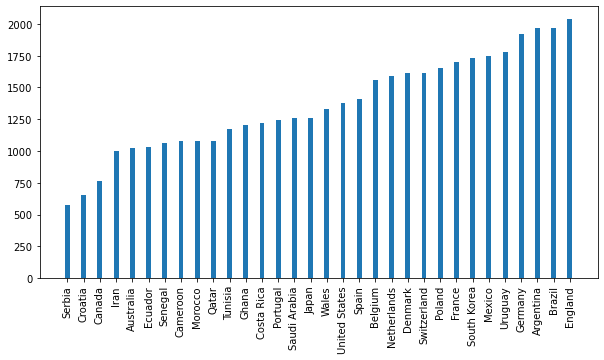

In [12]:
graph = (df_ml.team1.value_counts() + df_ml.team2.value_counts()).sort_values()
graph = graph[graph.index.isin(qualifiers)]

graph_x = graph.index
graph_y = graph.values

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.xticks(rotation="vertical")
plt.bar(height=graph_y, x=graph_x, width=0.3)
plt.show()

# We can see that our dataset isn't perfect since we have a lot of observations for 
# some teams and much less for others, but there is a good amount for each.

In [13]:
team1s = df.team1.unique()
team2s = df.team2.unique()

countries = np.unique(np.concatenate((team1s,team2s), axis=0))

In [14]:
label_encoder = preprocessing.LabelEncoder()

# We use "countries" if we work with the main dataframe,
# we use qualifiers if we work with the qualifiers only dataframe
label_encoder.fit(countries)
# label_encoder.fit(qualifiers)

df_labeled = df_ml.copy()
# df_labeled = df_ml_q.copy()


df_labeled["team1"] = label_encoder.transform(df_labeled["team1"])
df_labeled["team2"] = label_encoder.transform(df_labeled["team2"])

df_labeled["team1"] = df_labeled["team1"].astype("category")
df_labeled["team2"] = df_labeled["team2"].astype("category")


df_labeled

,year,team1,team2,team1_score,team2_score
0,2005,150,48,1,0
1,1984,209,51,4,0
2,2014,73,1,1,1
3,1971,140,119,6,0
4,2014,102,104,2,1
...,...,...,...,...,...
35545,1989,221,135,2,1
35546,2011,173,109,0,1
35547,1977,210,41,3,0
35548,2004,111,98,0,7


In [15]:
# Making our X, Y and Training and Testing samples
X = df_labeled.iloc[:,0:3]
Y = df_labeled.iloc[:,3:5]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10)

In [16]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier

model = MultiOutputRegressor(RandomForestClassifier())
model.fit(X_train,Y_train)

MultiOutputRegressor(estimator=RandomForestClassifier())

In [35]:
from sklearn.metrics import classification_report

def reporting(X, Y, model):
    predictions = model.predict(X)
    score_team1 = [score[0] for score in predictions]
    score_team2 = [score[1] for score in predictions]
    
    print("Classification Report Team 1")
    print(classification_report(Y.iloc[:,0], score_team1))
    print("Classification Report Team 2")
    print(classification_report(Y.iloc[:,1], score_team2))
    
    return score_team1, score_team2

In [36]:
print('Training Set')
training_report_team1, training_report_team2 = reporting(X_train, Y_train, model)
print('Testing Set')
testing_report_team1, testing_report_team2 = reporting(X_test, Y_test, model)

Training Set
Classification Report Team 1
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      9727
           1       0.89      0.90      0.89      9952
           2       0.88      0.87      0.88      6352
           3       0.88      0.85      0.86      3084
           4       0.88      0.84      0.86      1470
           5       0.89      0.81      0.85       672
           6       0.85      0.83      0.84       370
           7       0.90      0.84      0.87       183
           8       0.83      0.85      0.84       107
           9       0.88      0.90      0.89        48
          10       0.76      0.87      0.81        15
          11       0.83      1.00      0.91        10
          12       1.00      0.80      0.89         5

    accuracy                           0.89     31995
   macro avg       0.87      0.87      0.87     31995
weighted avg       0.89      0.89      0.89     31995

Classification Report Team 2
        

C:\Users\Chris\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# We can see that model does really well on training sample,
# but much worse on testing sample

# This means an overfitting problem that we should attempt to deal with. 
# Perhaps our models hyperparameters need tuning

The cell below takes long to compute. Est: 5-8 minutes

In [38]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14,16]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8,10]
# Create the random grid
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,}

rf_randomcv=RandomizedSearchCV(estimator=model,param_distributions=random_grid,n_iter=50,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
# fit to randomized rf
rf_randomcv.fit(X_train,Y_train)

# to see best parameters
print(rf_randomcv.best_params_)

# to make new classifier with the best estimator
best_random_grid=rf_randomcv.best_estimator_
print(best_random_grid)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.5min finished


{'estimator__n_estimators': 800, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 60}
MultiOutputRegressor(estimator=RandomForestClassifier(max_depth=60,
                                                      min_samples_split=10,
                                                      n_estimators=800))


In [40]:
best_random_grid.fit(X_train, Y_train)

MultiOutputRegressor(estimator=RandomForestClassifier(max_depth=60,
                                                      min_samples_split=10,
                                                      n_estimators=800))

In [43]:
print('Training Set')
training_score_team1, training_score_team2 = reporting(X_train, Y_train, best_random_grid)
print('Testing Set')
testing_score_team1, testing_score_team2 = reporting(X_test, Y_test, best_random_grid)

Training Set
Classification Report Team 1
              precision    recall  f1-score   support

           0       0.71      0.85      0.78      9727
           1       0.67      0.85      0.75      9952
           2       0.72      0.62      0.67      6352
           3       0.76      0.37      0.50      3084
           4       0.75      0.24      0.36      1470
           5       0.75      0.14      0.23       672
           6       0.72      0.12      0.20       370
           7       0.93      0.14      0.25       183
           8       0.83      0.05      0.09       107
           9       1.00      0.04      0.08        48
          10       1.00      0.13      0.24        15
          11       1.00      0.20      0.33        10
          12       0.00      0.00      0.00         5

    accuracy                           0.70     31995
   macro avg       0.76      0.29      0.34     31995
weighted avg       0.71      0.70      0.68     31995

Classification Report Team 2
        

C:\Users\Chris\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report Team 1
              precision    recall  f1-score   support

           0       0.40      0.49      0.44      1113
           1       0.33      0.44      0.38      1112
           2       0.20      0.16      0.18       680
           3       0.15      0.05      0.07       334
           4       0.16      0.03      0.05       167
           5       0.00      0.00      0.00        76
           6       0.00      0.00      0.00        32
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1

    accuracy                           0.33      3555
   macro avg       0.10      0.10      0.09      3555
weighted avg       0.29      0.33      0.30      3555

Classification Report Team 2
              precision    recall  f1-score   support

           0       0

C:\Users\Chris\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# But keep in mind that scores can vary a lot, but the games
# have only three possible outcomes: win, lose, draw

# Let's add these to our model and predictions, then
# see again how accurate our model is for predicting the outcome of 
# the games.

In [44]:
# adding outcome to testing sample and predictions

len_testing = len(testing_score_team1)
resault_testing=[]
resault_Y_test=[]
list_Y_test1=list(Y_test.team1_score)
list_Y_test2=list(Y_test.team2_score)


for i in range(len_testing):
    resault_testing.append(testing_score_team1[i]-testing_score_team2[i])
    if (resault_testing[i]>0):
        resault_testing[i]=1
    elif (resault_testing[i]<0):
        resault_testing[i]=-1
        
for i in range(len_testing):
    resault_Y_test.append(list_Y_test1[i]-list_Y_test2[i])
    if (resault_Y_test[i]>0):
        resault_Y_test[i]=1
    elif (resault_Y_test[i]<0):
        resault_Y_test[i]=-1

In [45]:
# adding outcome to training sample and predictions

len_training = len(training_score_team1)
resault_training=[]
resault_Y_train=[]
list_Y_train1=list(Y_train.team1_score)
list_Y_train2=list(Y_train.team2_score)


for i in range(len_training):
    resault_training.append(training_score_team1[i]-training_score_team2[i])
    if (resault_training[i]>0):
        resault_training[i]=1
    elif (resault_training[i]<0):
        resault_training[i]=-1
        
for i in range(len_training):
    resault_Y_train.append(list_Y_train1[i]-list_Y_train2[i])
    if (resault_Y_train[i]>0):
        resault_Y_train[i]=1
    elif (resault_Y_train[i]<0):
        resault_Y_train[i]=-1

In [46]:
# adding outcome to our machine learning dataframe

len_matches = len(df_ml.team1)
resault=[]
for i in range(len_matches):
    resault.append(df_ml.team1_score[i]-df_ml.team2_score[i])
    if (resault[i]>0):
        resault[i]=1
    elif (resault[i]<0):
        resault[i]=-1

In [47]:
df_ml["resault"]=resault

In [48]:
training_WINSreport_team1=classification_report(resault_Y_train,resault_training)
print(training_WINSreport_team1)

              precision    recall  f1-score   support

          -1       0.77      0.69      0.72     12261
           0       0.50      0.67      0.58      7485
           1       0.76      0.69      0.72     12249

    accuracy                           0.68     31995
   macro avg       0.68      0.68      0.68     31995
weighted avg       0.70      0.68      0.69     31995



In [49]:
testing_WINSreport_team1=classification_report(resault_Y_test,resault_testing)
print(testing_WINSreport_team1)

              precision    recall  f1-score   support

          -1       0.52      0.45      0.48      1352
           0       0.25      0.36      0.30       839
           1       0.53      0.45      0.49      1364

    accuracy                           0.43      3555
   macro avg       0.43      0.42      0.42      3555
weighted avg       0.46      0.43      0.44      3555



In [ ]:
# We can see that the accuracy for predicting wins on training is still much better
# than testing, but the overall accuracy improved.

In [50]:
# function to find who wins when given model prediction
def who_wins(predicted):
    if (predicted[0][0]>predicted[0][1]):
        return 0
    elif (predicted[0][0]<predicted[0][1]):
        return 1
    else:
        return 2

In [51]:
# sample predictions
team1="Wales"
team2="Iran"
year=2022

teamss=[team1,team2]
team1_labeled=label_encoder.transform([team1])[0]
team2_labeled=label_encoder.transform([team2])[0]

X_sample=np.array([[year,team1_labeled,team2_labeled]])
sample_out = model.predict(X_sample)
winner=who_wins(sample_out)

try:
    print("winner is %s score:%d-%d" %(teamss[winner],sample_out[0][0],sample_out[0][1]))
except IndexError:
    print("match is draw score: %d-%d" %(sample_out[0][0], sample_out[0][1]))

winner is Wales score:1-0


In [52]:
penalties = penalties[penalties["team1"].isin(qualifiers) | penalties["team2"].isin(qualifiers)]
penalties.head()

,date,team1,team2,winner
1,1971-11-14,South Korea,Vietnam Republic,South Korea
2,1972-05-17,Thailand,South Korea,South Korea
4,1973-04-21,Senegal,Ghana,Ghana
10,1973-07-28,Myanmar,South Korea,Myanmar
14,1974-03-28,Qatar,United Arab Emirates,Qatar


In [53]:
class Team():
    def __init__(self, name):
        self.name = name
        self.goals_scored = 0
        self.goals_received = 0
        self.win = 0
        self.lose = 0
        self.draw = 0
        self.total_points = 0
        self.penalty_prc = 0.5

In [54]:
teams = {}

# Making a class object for each team
for cntry in qualifiers:
    teams[cntry] = Team(cntry)
    
    sumP = penalties[penalties.team1 == cntry].shape[0] + penalties[penalties.team2 == cntry].shape[0]
    sumW = penalties[penalties.winner == cntry].shape[0]
    
    if (sumP>0):
        teams[cntry].penalty_prc = (sumW/sumP)

In [56]:
import warnings
warnings.filterwarnings("ignore")

# Group Stage
# Win=3, lose=0, draw=1  points
# top two teams in each group advance

len_group = 4
year = 2022

for group in list(Groups.keys()):
    Countries=Groups[group]
    print("%s games:" %group)
    for i in range(len_group):
        j=i+1
        team1 = Countries[i]
        team1_label = label_encoder.transform([team1])[0]
        while (j<len_group):
            team2 = Countries[j]
            team2_label = label_encoder.transform([team2])[0]
            match=[team1,team2]
            
            X_temp = np.array([[year,team1_label,team2_label]])
            out = model.predict(X_temp)
            winner = who_wins(out)
            
            teams[team1].goals_scored += out[0][0]
            teams[team1].goals_received += out[0][1]
            teams[team2].goals_scored += out[0][1]
            teams[team2].goals_received += out[0][0]
            
            try:
                print("   %s vs %s,   winner: %s,   score: %d-%d\n" %(team1,team2,match[winner],out[0][0],out[0][1]))
                
                if (winner==0):
                    teams[team1].win += 1
                    teams[team1].total_points += 3
                    teams[team2].lose += 1
                
                elif (winner==1):
                    teams[team2].win += 1
                    teams[team2].total_points += 3
                    teams[team1].lose += 1
                    
            
            except IndexError:
                print("   %s vs %s,   match ended with a draw,   score: %d-%d\n" %(team1,team2,out[0][0],out[0][1]))
                
                teams[team1].draw += 1
                teams[team2].draw += 1
                teams[team1].total_points += 1
                teams[team2].total_points += 1
                
            j=j+1         

Group A games:
   Qatar vs Ecuador,   winner: Ecuador,   score: 0-2

   Qatar vs Senegal,   winner: Senegal,   score: 2-3

   Qatar vs Netherlands,   winner: Qatar,   score: 1-0

   Ecuador vs Senegal,   match ended with a draw,   score: 0-0

   Ecuador vs Netherlands,   match ended with a draw,   score: 0-0

   Senegal vs Netherlands,   winner: Senegal,   score: 1-0

Group B games:
   England vs Iran,   winner: England,   score: 2-0

   England vs United States,   winner: United States,   score: 1-2

   England vs Wales,   winner: England,   score: 3-1

   Iran vs United States,   match ended with a draw,   score: 1-1

   Iran vs Wales,   winner: Wales,   score: 0-1

   United States vs Wales,   match ended with a draw,   score: 0-0

Group C games:
   Argentina vs Saudi Arabia,   winner: Saudi Arabia,   score: 1-2

   Argentina vs Mexico,   match ended with a draw,   score: 0-0

   Argentina vs Poland,   winner: Poland,   score: 0-3

   Saudi Arabia vs Mexico,   winner: Saudi Arabia, 

In [81]:
standings_A = []
standings_B = []
standings_C = []
standings_D = []
standings_E = []
standings_F = []
standings_G = []
standings_H = []

def sort_stand(group_, listy):
    for j in group_:
        listy.append(teams[j])
        
    listy = sorted(listy, key=lambda i: (i.total_points, (i.goals_scored-i.goals_received), i.goals_scored), reverse=True)
    
    return listy

In [82]:
standings_A = sort_stand(Group_A, standings_A)
standings_B = sort_stand(Group_B, standings_B)
standings_C = sort_stand(Group_C, standings_C)
standings_D = sort_stand(Group_D, standings_D)
standings_E = sort_stand(Group_E, standings_E)
standings_F = sort_stand(Group_F, standings_F)
standings_G = sort_stand(Group_G, standings_G)
standings_H = sort_stand(Group_H, standings_H)

# standings = [standings_A,standings_B,standings_C,standings_D,standings_E,standings_F,standings_G,standings_H]
# for standing in standings:
#     print(standing[0].name)
# # standings = pd.DataFrame([standings_A,standings_B,standings_C,standings_D,standings_E,standings_F,standings_G,standings_H])
# # print(standings)

In [83]:
# function for determining the qualified teams
def qualifyer(standings_one, standings_two, top_):
    team1=standings_one[0].name
    team2=standings_two[1].name
    team1_label = label_encoder.transform([team1])[0]
    team2_label = label_encoder.transform([team2])[0]
    match=[team1,team2]

    X_temp = np.array([[year,team1_label,team2_label]])
    out = model.predict(X_temp)
    winner = who_wins(out)

    try:
        print("   %s vs %s,   winner: %s,   score: %d-%d\n" %(team1,team2,match[winner],out[0][0],out[0][1]))
        
    except IndexError:
        if (teams[team1].penalty_prc>teams[team2].penalty_prc):
            winner = 0

        elif (teams[team1].penalty_prc<teams[team2].penalty_prc):
            winner = 1
            
        else:
            winner = random.choice([0,1])

        print("   %s vs %s,   match went to penalty,   winner: %s\n" %(team1,team2,match[winner]))
    top_.append(match[winner])
    return top_

In [84]:
top_8=[]
top_8 = qualifyer(standings_A, standings_B, top_8)
top_8 = qualifyer(standings_B, standings_A, top_8)
top_8 = qualifyer(standings_C, standings_D, top_8)
top_8 = qualifyer(standings_D, standings_C, top_8)
top_8 = qualifyer(standings_E, standings_F, top_8)
top_8 = qualifyer(standings_F, standings_E, top_8)
top_8 = qualifyer(standings_G, standings_H, top_=top_8)
top_8 = qualifyer(standings_H, standings_G, top_=top_8)

   Senegal vs United States,   winner: United States,   score: 0-2

   England vs Ecuador,   match went to penalty,   winner: Ecuador

   Saudi Arabia vs France,   match went to penalty,   winner: Saudi Arabia

   Tunisia vs Poland,   match went to penalty,   winner: Poland

   Germany vs Canada,   winner: Germany,   score: 1-0

   Morocco vs Japan,   match went to penalty,   winner: Japan

   Switzerland vs Uruguay,   winner: Uruguay,   score: 0-7

   South Korea vs Serbia,   winner: Serbia,   score: 2-3

